# Прогностическая модель рисков беременных

##Цель исследования


Цель исследования заключается в разработке прогностической модели, способной предсказывать уровень риска во время беременности на основе нескольких физиологических показателей. Эта модель может помочь медицинским специалистам своевременно выявлять беременных женщин с высоким риском и направлять их на более тщательное наблюдение и лечение.

##Задача

Задача: создать прогностическую модель рисков беременных.




##Описание данных


Age: Age in years when a woman is pregnant.  

SystolicBP: Upper value of Blood Pressure in mmHg, another significant attribute during pregnancy.  

DiastolicBP: Lower value of Blood Pressure in mmHg, another significant attribute during pregnancy.  

BS: Blood glucose levels is in terms of a molar concentration, mmol/L.

HeartRate: A normal resting heart rate in beats per minute.  

Risk Level: Predicted Risk Intensity Level during pregnancy considering the previous attribute.

##Импорт библиотек

In [ ]:
!pip install phik xgboost


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 686.1/686.1 kB 1.1 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import phik
from phik import resources, report

from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder, label_binarize
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils.class_weight import compute_sample_weight

from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score, roc_auc_score, roc_curve, auc, make_scorer, fbeta_score

import xgboost as xgb


##Константы

In [ ]:
RANDOM_STATE = 42


##Импорт данных

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#%cd  /content/drive/MyDrive/datasets/pregnancy/

/content/drive/MyDrive/datasets/pregnancy


In [ ]:
df = pd.read_csv('Maternal Health Risk Data Set.csv')

##Обзор данных

In [ ]:
df.head()

,Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate,RiskLevel
0,25,130,80,15.0,98.0,86,high risk
1,35,140,90,13.0,98.0,70,high risk
2,29,90,70,8.0,100.0,80,high risk
3,30,140,85,7.0,98.0,70,high risk
4,35,120,60,6.1,98.0,76,low risk


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1014 entries, 0 to 1013
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Age          1014 non-null   int64  
 1   SystolicBP   1014 non-null   int64  
 2   DiastolicBP  1014 non-null   int64  
 3   BS           1014 non-null   float64
 4   BodyTemp     1014 non-null   float64
 5   HeartRate    1014 non-null   int64  
 6   RiskLevel    1014 non-null   object 
dtypes: float64(2), int64(4), object(1)
memory usage: 55.6+ KB


In [ ]:
df.describe()

,Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate
count,1014.000000,1014.000000,1014.000000,1014.000000,1014.000000,1014.000000
mean,29.871795,113.198225,76.460552,8.725986,98.665089,74.301775
std,13.474386,18.403913,13.885796,3.293532,1.371384,8.088702
min,10.000000,70.000000,49.000000,6.000000,98.000000,7.000000
25%,19.000000,100.000000,65.000000,6.900000,98.000000,70.000000
50%,26.000000,120.000000,80.000000,7.500000,98.000000,76.000000
75%,39.000000,120.000000,90.000000,8.000000,98.000000,80.000000
max,70.000000,160.000000,100.000000,19.000000,103.000000,90.000000


In [ ]:
df.isnull().sum()

,0
Age,0
SystolicBP,0
DiastolicBP,0
BS,0
BodyTemp,0
HeartRate,0
RiskLevel,0


В датасете 1014 записей и 7 столбцов, включая признаки: возраст, систолическое и диастолическое давление, уровень сахара, температуру тела, частоту сердцебиения и уровень риска. Пропущенных значений нет.  Целевая переменная - RiskLevel

##Очистка данных

In [ ]:
df.columns=[x.lower() for x in df.columns]

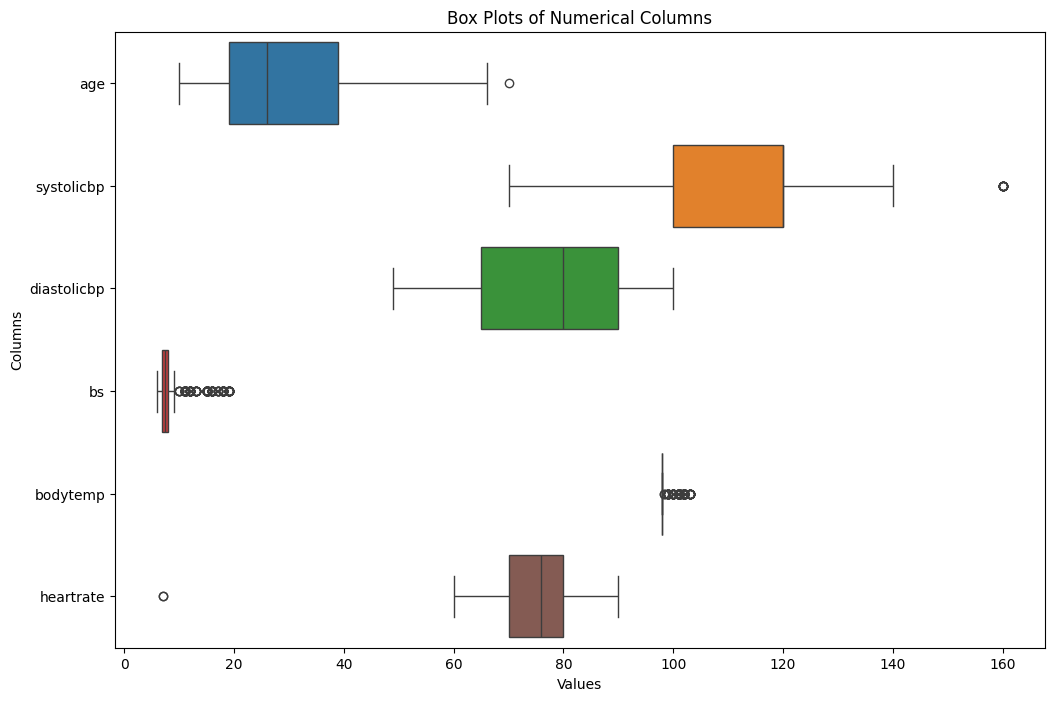

In [ ]:
# Creating a figure and axes
plt.figure(figsize=(12, 8))

numeric_columns = df.select_dtypes(include=['float64', 'int64']).columns


sns.boxplot(data=df[numeric_columns], orient='h')
plt.title('Box Plots of Numerical Columns')
plt.xlabel('Values')
plt.ylabel('Columns')

# Display the plot
plt.show()

In [ ]:
# Function to calculate outlier indices for a given column
def outlier_indices(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    return data[(data[column] < lower_bound) | (data[column] > upper_bound)].index

outliers_dict = {}

# Identify and record outliers' indices for each numeric column
for col in df.select_dtypes(include=['float64', 'int64']).columns:
    col_outliers = outlier_indices(df, col)
    if not col_outliers.empty:
        outliers_dict[col] = col_outliers

        print(f"Column '{col}' has {len(col_outliers)} outliers.")

# Combine all outlier indices across columns
all_outlier_indices = set()
for indices in outliers_dict.values():
    all_outlier_indices.update(indices)

print("Original DataFrame size:", len(df))


Column 'age' has 1 outliers.
Column 'systolicbp' has 10 outliers.
Column 'bs' has 210 outliers.
Column 'bodytemp' has 210 outliers.
Column 'heartrate' has 2 outliers.
Original DataFrame size: 1014


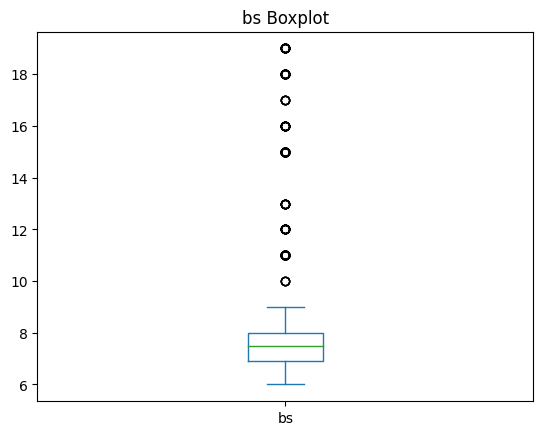

In [ ]:
df['bs'].plot(kind='box', title='bs Boxplot')
plt.show()


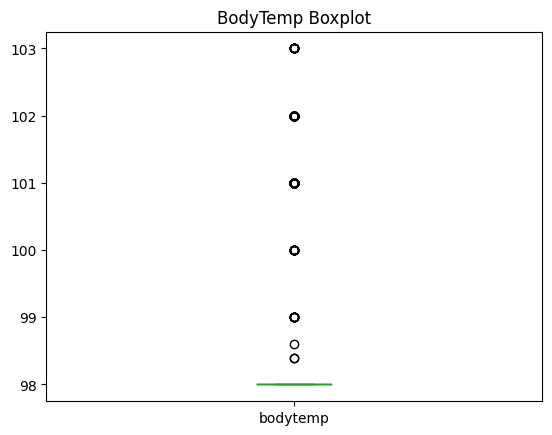

In [ ]:
df['bodytemp'].plot(kind='box', title='BodyTemp Boxplot')
plt.show()

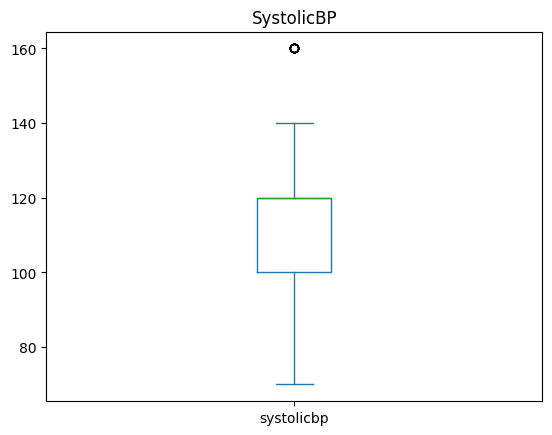

In [ ]:
df['systolicbp'].plot(kind='box', title='SystolicBP')
plt.show()


In [ ]:
columns_to_check = ['age', 'heartrate']
selected_outlier_indices = set()
for col in columns_to_check:
    if col in outliers_dict:
        selected_outlier_indices.update(outliers_dict[col])


df = df.drop(index=selected_outlier_indices)


print("New DataFrame size without outliers from 'age' and 'heartrate':", len(df))

New DataFrame size without outliers from 'age' and 'heartrate': 1011


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1011 entries, 0 to 1013
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   age          1011 non-null   int64  
 1   systolicbp   1011 non-null   int64  
 2   diastolicbp  1011 non-null   int64  
 3   bs           1011 non-null   float64
 4   bodytemp     1011 non-null   float64
 5   heartrate    1011 non-null   int64  
 6   risklevel    1011 non-null   object 
dtypes: float64(2), int64(4), object(1)
memory usage: 63.2+ KB


Анализ распределений показал наличие выбросов:  

В датасете всего 1014 записей. Возраст имеет 1 выброс, а частота сердцебиения — 2 выброса. Выбросы для систолического давления (10 выбросов), уровня сахара и температуры тела (по 210 выбросов) не кажутся ошибками данных, так как такие значения могут быть связаны с физиологическими особенностями, например, гипертонией, диабетом или воспалительными процессами. Было решено удалить только записи с 1-2 выбросами.После удаления выбросов осталось 1011 записей.

##Визуализация данных

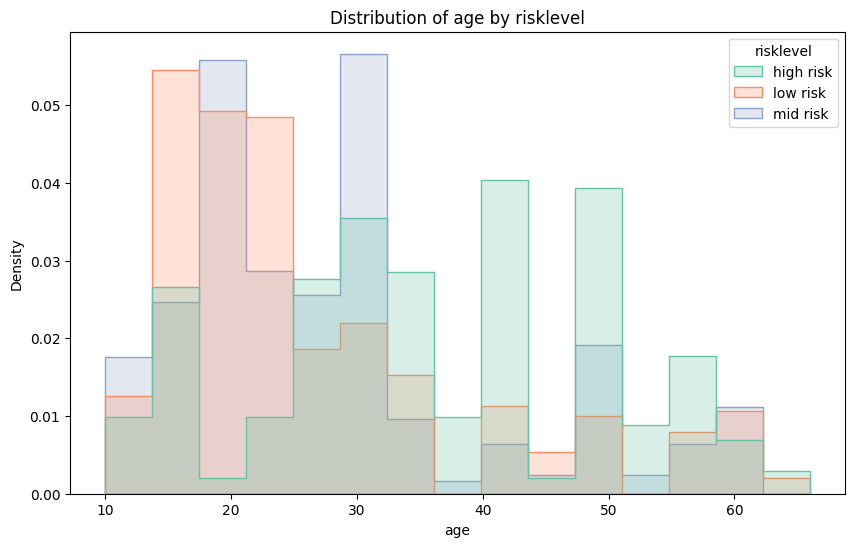

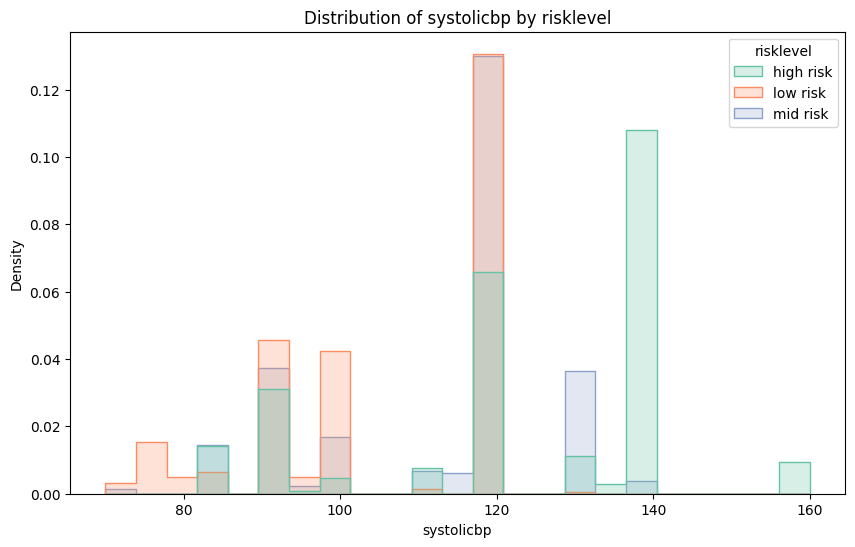

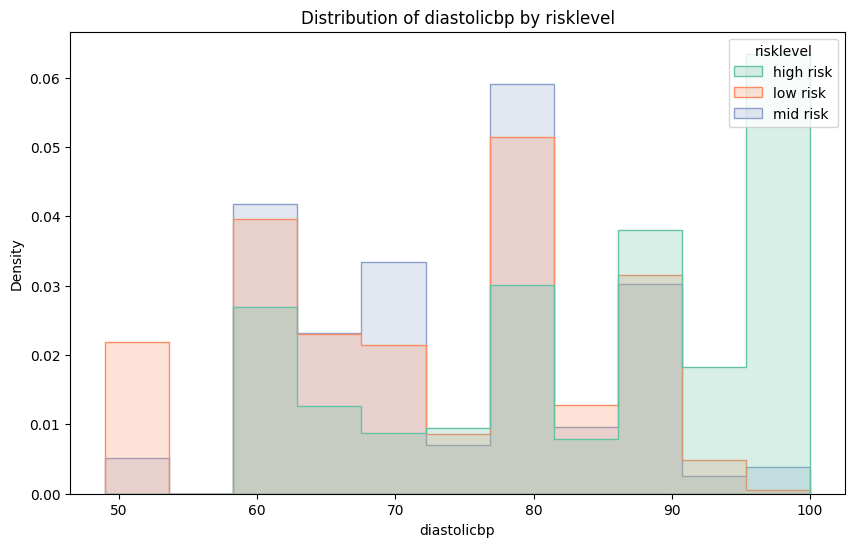

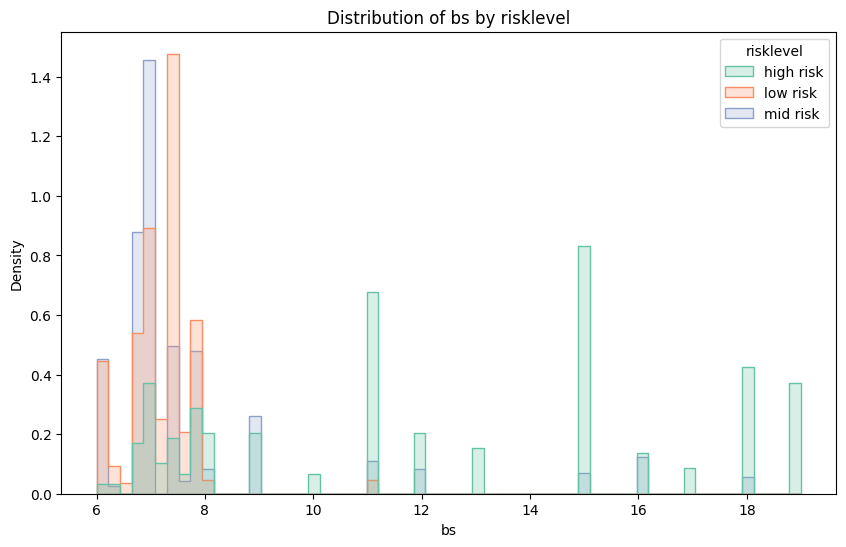

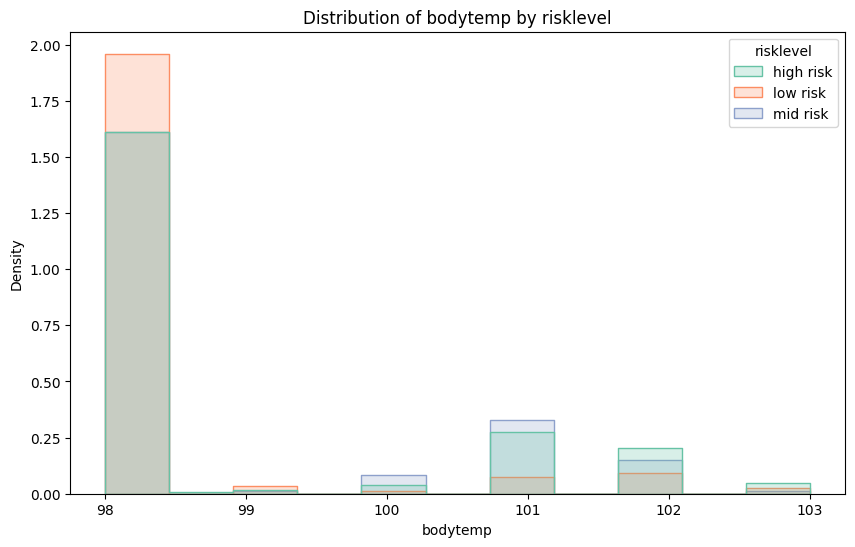

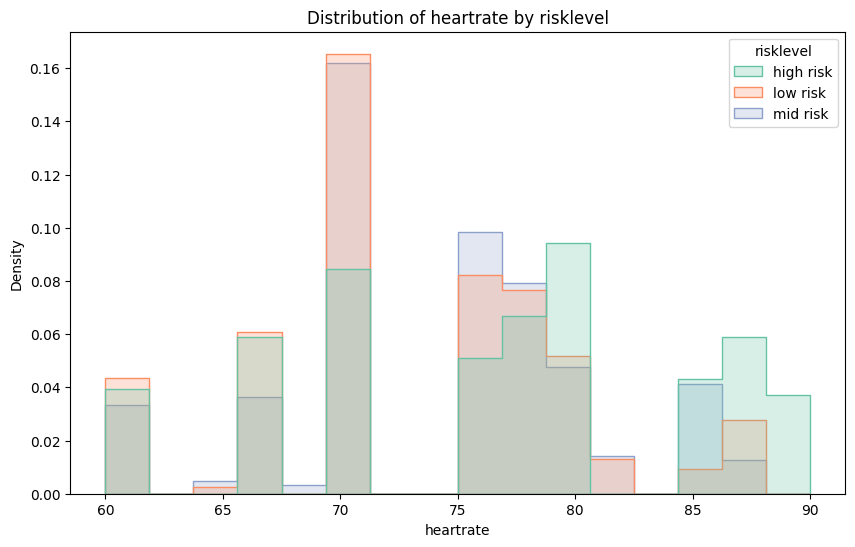

In [ ]:
columns_to_plot = df.columns[df.columns != 'risklevel']
palette = sns.color_palette("Set2", n_colors=3)
for column in columns_to_plot:
    plt.figure(figsize=(10, 6))
    if df[column].dtype in ['int64', 'float64']:
        sns.histplot(data=df, x=column, hue='risklevel', element='step', stat='density', common_norm=False, palette=palette)
        plt.title(f'Distribution of {column} by risklevel')

    elif df[column].dtype == 'object':
        sns.countplot(data=df, x=column, hue='risklevel', palette=palette)
        plt.title(f'Count of {column} by risklevel')
        plt.xticks(rotation=45)
    plt.show()

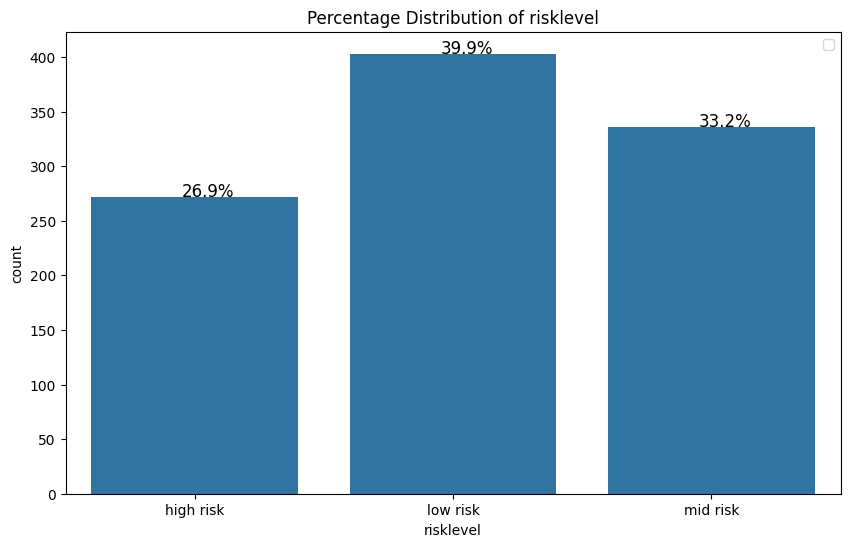

In [ ]:
plt.figure(figsize=(10, 6))
ax = sns.countplot(x='risklevel', data=df)
plt.title('Percentage Distribution of risklevel')
total = len(df['risklevel'])
for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height() / total)
    x = p.get_x() + p.get_width() / 2 - 0.05
    y = p.get_y() + p.get_height()
    ax.annotate(percentage, (x, y), size = 12)
plt.legend()
plt.show()

Для каждого числового признака были построены гистограммы с разбивкой по уровням риска. Это позволило увидеть, как распределяются признаки, такие как возраст, давление, уровень сахара и температура тела, в зависимости от уровня риска.
Видно, что некоторые признаки, например, уровень сахара и давление, могут существенно влиять на классификацию уровня риска.

Распределение уровней риска:
Процентное распределение показало, что среди всех данных:
26.9% случаев имеют высокий риск.
39.9% — низкий риск.
33.2% — средний риск.
Это указывает на  почти сбалансированное распределение классов, что важно для обучения модели.

## Корреляционный анализ

In [ ]:
numeric_cols = ['age', 'systolicbp', 'diastolicbp', 'bs', 'heartrate', 'bodytemp']

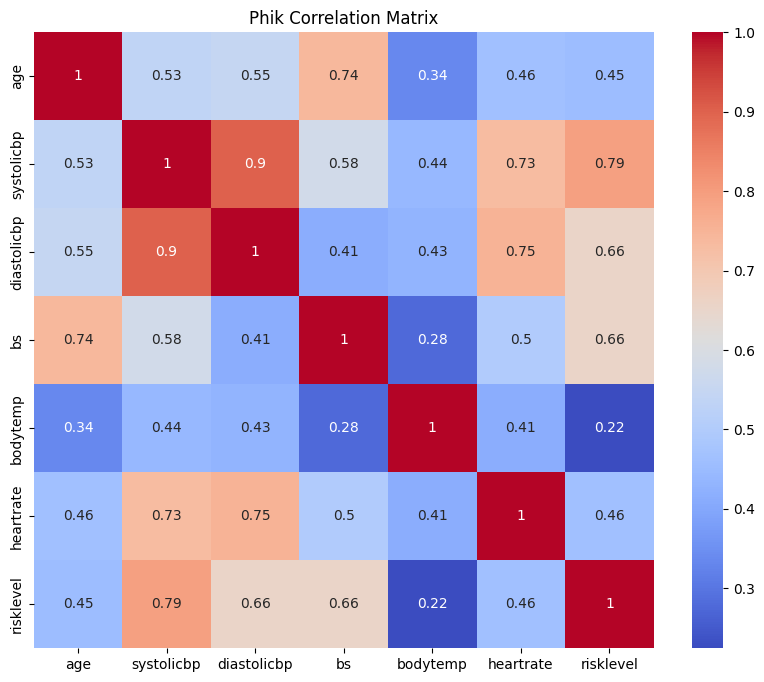

In [ ]:
# Calculate the phik correlation matrix
phik_matrix = df.phik_matrix(interval_cols=numeric_cols)


plt.figure(figsize=(10, 8))
sns.heatmap(phik_matrix, annot=True, cmap='coolwarm')
plt.title('Phik Correlation Matrix')
plt.show()

На основе представленной Phik корреляционной матрицы можно сделать следующие выводы:

1. **Весьма высокая корреляция между SystolicBP и DiastolicBP:**
   - Взаимосвязь между систолическим и диастолическим давлением (SystolicBP и DiastolicBP) весьма высока (0.9). Это ожидаемо, так как оба показателя измеряют давление крови, но в разных фазах сердечного цикла, и обычно они тесно связаны.

2. **Высокая корреляция между RiskLevel и SystolicBP:**
   - Уровень риска (RiskLevel) показывает высокую корреляцию с SystolicBP (0.79) и заметную корреляцию с DiastolicBP (0.66). Это указывает на то, что артериальное давление играет важную роль в определении уровня риска у беременных женщин. Высокое давление может быть значимым фактором риска.

3. **Высокая корреляция между BS и Age:**
   - Возраст (Age) и уровень глюкозы в крови (BS) имеют высокую корреляцию (0.74). Это может указывать на тенденцию к повышению уровня глюкозы с возрастом, что часто наблюдается в клинической практике.

4. **Высокая связь между HeartRate и SystolicBP/DiastolicBP:**
   - Частота сердечных сокращений (HeartRate) коррелирует с показателями артериального давления (0.73 с SystolicBP и 0.75 с DiastolicBP). Это также логично, поскольку повышенное давление может приводить к изменению частоты сердечных сокращений.

5. **Слабая корреляция между BodyTemp и другими показателями:**
   - Температура тела (BodyTemp) показывает слабую корреляцию с другими переменными, включая уровень риска (0.22). Это может означать, что температура тела не является значительным предиктором для этих других показателей или уровня риска в данном наборе данных.

6. **Корреляция между Age и другими переменными:**
   - Возраст имеет заметную корреляцию с давлением и частотой сердечных сокращений, но особенно высокую с уровнем глюкозы в крови (0.74). Это подчеркивает возможное влияние возраста на некоторые физиологические параметры.

Общие выводы:

- **Артериальное давление** является важным фактором риска, что подтверждается его высокой корреляцией с уровнем риска (RiskLevel).
- **Возраст и уровень глюкозы** также связаны между собой и могут влиять на другие переменные, особенно на уровень риска.
- **Температура тела** имеет слабую корреляцию с другими параметрами, что может свидетельствовать о её меньшем влиянии на уровень риска в этом контексте.


In [ ]:
X = df[['systolicbp', 'diastolicbp', 'bs', 'age', 'heartrate', 'bodytemp']]
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]

print(vif_data)

       feature         VIF
0   systolicbp  105.898180
1  diastolicbp   85.343789
2           bs   11.707593
3          age    8.452479
4    heartrate  103.942209
5     bodytemp  140.655494



Исходя из результатов корреляционного анализа некоторые признаки имеют высокую мультиколлинеарность, это необходимо учитывать в обучении модели.
PCA из-за небольшого количества признаков лучше не испольщовать . Исходя из этого рационально будет использовать здесь модели,  которые хорошо справляются с мультиколлинеарностью и не требуют независимости признаков.

В контексте использования моделей Random Forest и XGBoost, нормализация и стандартизация данных не являются необходимыми. Оба этих метода относятся к классу моделей, основанных на деревьях решений, и они не чувствительны к масштабу признаков

##Feature engineering

In [ ]:
df['risklevel'] = df['risklevel'].map({'low risk': 0, 'mid risk': 1, 'high risk': 2})

In [ ]:
df.head()

,age,systolicbp,diastolicbp,bs,bodytemp,heartrate,risklevel
0,25,130,80,15.0,98.0,86,2
1,35,140,90,13.0,98.0,70,2
2,29,90,70,8.0,100.0,80,2
3,30,140,85,7.0,98.0,70,2
4,35,120,60,6.1,98.0,76,0


In [ ]:
#add new feature age_group
bins = [0, 20, 30, 50, 100]
labels = ['Child/Teen', 'Young Adult', 'Middle-aged', 'Senior']
df['age_group'] = pd.cut(df['age'], bins=bins, labels=labels, right=False)

In [ ]:
df.head()

,age,systolicbp,diastolicbp,bs,bodytemp,heartrate,risklevel,age_group
0,25,130,80,15.0,98.0,86,2,Young Adult
1,35,140,90,13.0,98.0,70,2,Middle-aged
2,29,90,70,8.0,100.0,80,2,Young Adult
3,30,140,85,7.0,98.0,70,2,Middle-aged
4,35,120,60,6.1,98.0,76,0,Middle-aged


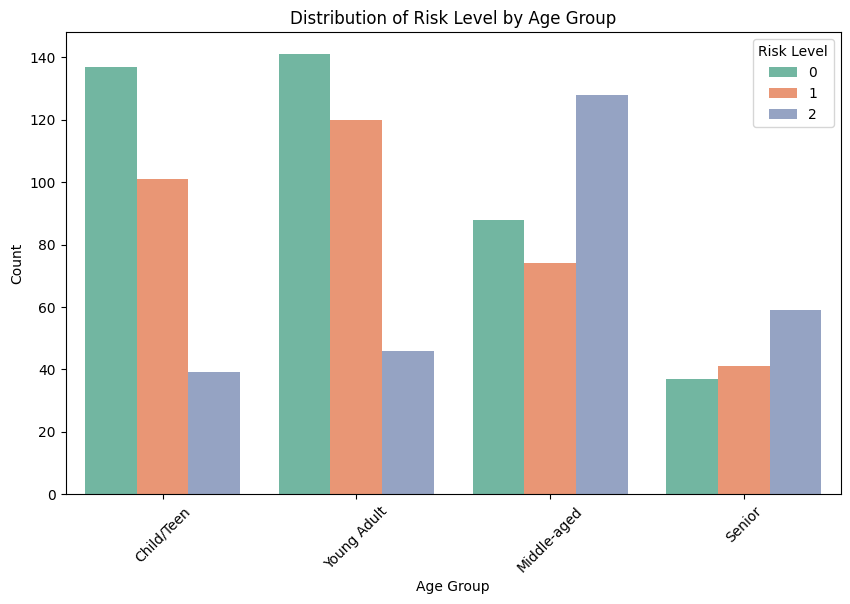

In [ ]:
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='age_group', hue='risklevel', palette='Set2')
plt.title('Distribution of Risk Level by Age Group')
plt.xlabel('Age Group')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(title='Risk Level')
plt.show()


Фича age_group введена для учета того, что возраст по-разному влияет на риск во время беременности. Разделение на возрастные группы помогает лучше выделить высокорисковые категории и учесть нелинейную зависимость риска от возраста, что улучшает интерпретируемость и потенциал модели.

In [ ]:
df['bp_ratio'] = df['systolicbp'] / df['diastolicbp']

In [ ]:
df['bp_diff'] = df['systolicbp'] - df['diastolicbp']

In [ ]:
df['bs_systolic_ratio'] = df['bs'] / df['systolicbp']

In [ ]:
df['bs_age_ratio'] = df['bs'] / df['age']

bp_ratio — соотношение систолического и диастолического давления. Это может показать сбалансированность кровяного давления, так как соотношение может сигнализировать о рисках, связанных с давлением.  
bp_diff — разница между систолическим и диастолическим давлением. Эта фича может указать на аномалии в работе сердечно-сосудистой системы, где большая разница может быть маркером повышенного риска.  
bs_systolic_ratio — соотношение уровня сахара к систолическому давлению. Это важно, поскольку высокий уровень сахара и давление могут усиливать риск осложнений во время беременности.  
bs_age_ratio — соотношение уровня сахара к возрасту. Учитывает, что с возрастом склонность к повышенному уровню сахара увеличивается, что может усилить риски для пожилых женщин.

##Предобработка данных

In [ ]:
# Split the data into features and target variable
X = df.drop('risklevel', axis=1)
y = df['risklevel']

In [ ]:

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y)

In [ ]:
# Save the feature names before the transformation
feature_names = X_train.columns

In [ ]:
categorical_features = ['age_group']
numerical_features = ['bs_systolic_ratio','bodytemp', 'heartrate', 'bp_ratio','bp_diff','bs_age_ratio'] #'systolicbp', 'diastolicbp'
X_train_numerical = X_train[numerical_features]
X_test_numerical = X_test[numerical_features]
#standardization
standard_scaler = StandardScaler()
X_train_numerical = standard_scaler.fit_transform(X_train_numerical)
X_test_numerical = standard_scaler.transform(X_test_numerical)

one_hot_encoder = OneHotEncoder(sparse=False, drop='first')
X_train_categorical = one_hot_encoder.fit_transform(X_train[categorical_features])
X_test_categorical = one_hot_encoder.transform(X_test[categorical_features])


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [ ]:
X_train = np.hstack((X_train_numerical, X_train_categorical))
X_test = np.hstack((X_test_numerical, X_test_categorical))


In [ ]:
X_train.shape

(808, 9)

In [ ]:
X_test.shape

(203, 9)

В ходе предобработки данных был выполнен следующий процесс:

Данные разделены на обучающую и тестовую выборки с использованием стратифицированного разбиения.  

Для числовых признаков применена стандартизация (StandardScaler), чтобы привести данные к единому масштабу.  

Категориальные признаки преобразованы с помощью One-Hot Encoding для корректной обработки моделей.  


## Моделирование и Оценка


Было решено выбрать модели Random Forest и XGBoost. Random Forest устойчив к выбросам и мультиколлинеарности, что важно для показателей, таких как давление и уровень сахара, в то время как XGBoost, благодаря регуляризации и бустингу, помогает минимизировать ошибки и повышает точность модели на сложных данных.

Для оценки моделей были выбраны метрики F2 Score и ROC-AUC. F2 Score акцентирует внимание на полноте, что критично при прогнозировании высокого риска у беременных — ошибки здесь могут привести к серьезным последствиям для здоровья. ROC-AUC помогает оценить, насколько хорошо модель различает классы, особенно высоко- и среднерисковые, потому что важно своевременно выявить пациентов с повышенными рисками. Различение этих классов может напрямую влиять на медицинские решения и стратегии ведения беременности, чтобы предотвратить осложнения.

###**Random forest**

In [ ]:
def train_random_forest(X_train, y_train):
    # Define the parameter grid for hyperparameter tuning
    param_grid = {
        'n_estimators': [200,300],
        'max_depth': [10, 15,20],
        'min_samples_split': [2,3],
        'min_samples_leaf': [1,2],

    }

    # Create a custom scorer using F2 Score
    f2_scorer = make_scorer(fbeta_score, beta=2, average='weighted')

    # Initialize StratifiedKFold for cross-validation
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

    # Initialize the RandomForestClassifier
    rf_model = RandomForestClassifier(random_state=RANDOM_STATE)

    # Initialize GridSearchCV
    grid_search = GridSearchCV(estimator=rf_model,
                               param_grid=param_grid,
                               scoring=f2_scorer,  # Use F2 score as the metric
                               cv=skf,
                               n_jobs=-1,
                               verbose=1)

    print("Starting grid search...")
    grid_search.fit(X_train, y_train)

    print("Grid search completed.")
    print("Best parameters found: ", grid_search.best_params_)
    print("Best cross-validation F2 Score: %.2f" % grid_search.best_score_)

    # Return the best model found by GridSearchCV
    return grid_search.best_estimator_, grid_search.best_params_

In [ ]:
best_rf_model, best_rf_params = train_random_forest(X_train, y_train)

Starting grid search...
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Grid search completed.
Best parameters found:  {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 300}
Best cross-validation F2 Score: 0.83


In [ ]:
def evaluate_random_forest(model, X_train, y_train, X_test, y_test):
    # Predictions on training data
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # Probabilities for ROC-AUC
    y_train_proba = model.predict_proba(X_train)
    y_test_proba = model.predict_proba(X_test)

    # Evaluation metrics for training data
    train_f2 = fbeta_score(y_train, y_train_pred, beta=2, average='weighted')
    train_accuracy = accuracy_score(y_train, y_train_pred)
    train_roc_auc = roc_auc_score(y_train, y_train_proba, multi_class='ovo', average='weighted')

    print("Train Metrics:")
    print(f"F2 Score (weighted): {train_f2}")
    print(f"Accuracy: {train_accuracy}")
    print(f"ROC-AUC (weighted): {train_roc_auc}")

    # Evaluation metrics for test data
    test_f2 = fbeta_score(y_test, y_test_pred, beta=2, average='weighted')
    test_accuracy = accuracy_score(y_test, y_test_pred)
    test_roc_auc = roc_auc_score(y_test, y_test_proba, multi_class='ovo', average='weighted')

    print("Test Metrics:")
    print(f"F2 Score (weighted): {test_f2}")
    print(f"Accuracy: {test_accuracy}")
    print(f"ROC-AUC (weighted): {test_roc_auc}")

    # Optionally, add F1 score as additional information
    test_f1 = f1_score(y_test, y_test_pred, average='weighted')
    print(f"F1 Score (weighted) [optional]: {test_f1}")

    # Confusion matrix for training data
    print("Plotting confusion matrix for training data...")
    train_cm = confusion_matrix(y_train, y_train_pred)
    sns.heatmap(train_cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Train Confusion Matrix')
    plt.show()

    # Plot Confusion Matrix for test data
    test_cm = confusion_matrix(y_test, y_test_pred)
    sns.heatmap(test_cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Test Confusion Matrix')
    plt.show()


Train Metrics:
F2 Score (weighted): 0.9292192979290276
Accuracy: 0.9294554455445545
ROC-AUC (weighted): 0.9915622147710113
Test Metrics:
F2 Score (weighted): 0.856502246669223
Accuracy: 0.8571428571428571
ROC-AUC (weighted): 0.9545904642748013
F1 Score (weighted) [optional]: 0.8559575991720607
Plotting confusion matrix for training data...


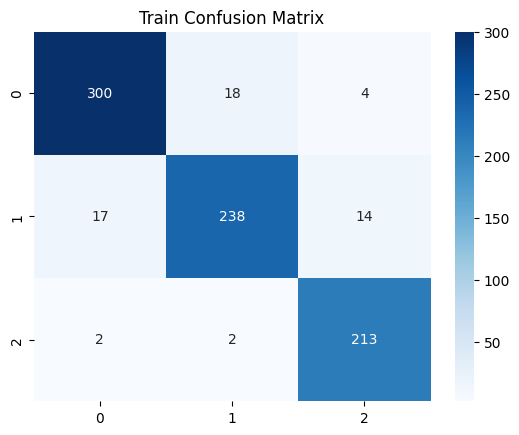

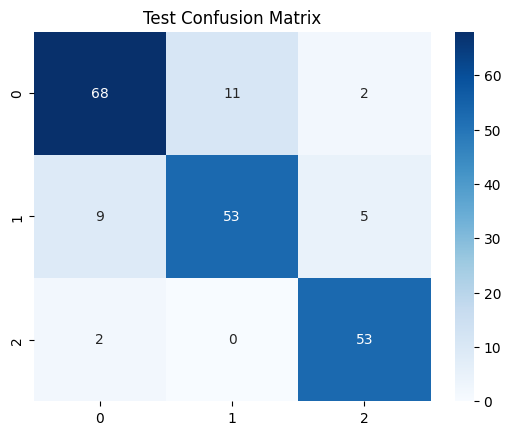

In [ ]:
evaluate_random_forest(best_rf_model, X_train, y_train, X_test, y_test)

In [ ]:
# Feature importance analysis
def plot_feature_importances(model, feature_names):
    # Get feature importances from the model
    importances = model.feature_importances_

    # Create a DataFrame to organize features by importance
    feature_importances = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
    feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

    # Plotting the feature importances
    plt.figure(figsize=(10, 8))
    sns.barplot(x='Importance', y='Feature', data=feature_importances)
    plt.title('Feature Importances')
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.show()



In [ ]:

numerical_feature_names = numerical_features
categorical_feature_names = one_hot_encoder.get_feature_names_out(categorical_features)
feature_names = np.hstack([numerical_feature_names, categorical_feature_names])



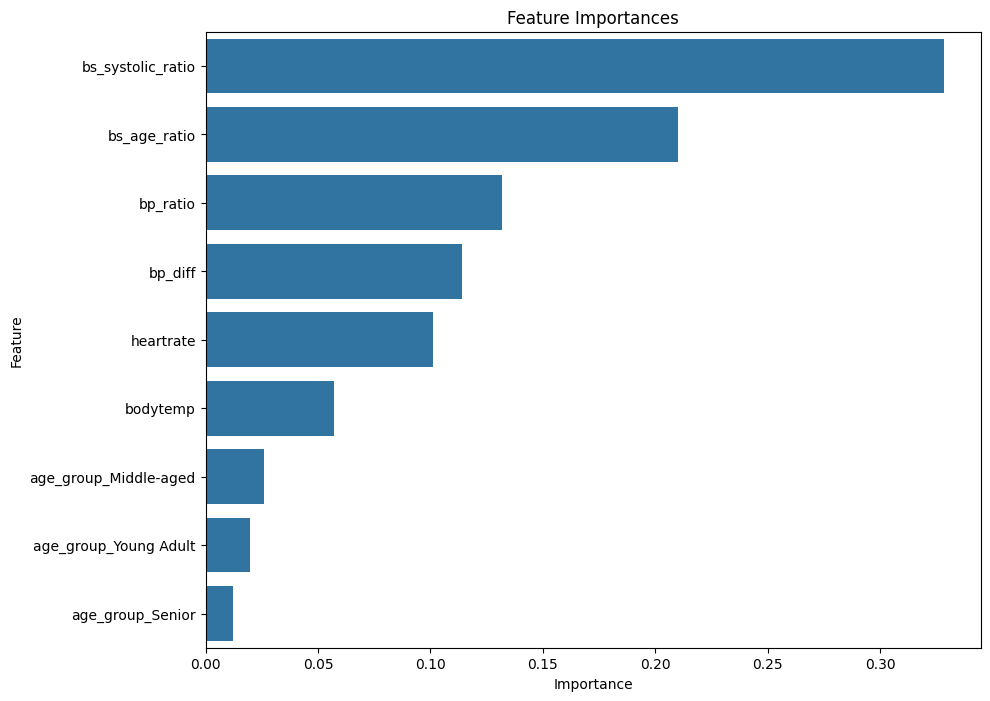

In [ ]:
# Plotting the feature importances
plot_feature_importances(best_rf_model, feature_names)

Важнейшими признаками для модели Random Forest оказались отношения уровня сахара к систолическому давлению и возрасту, что подчеркивает значимость уровня глюкозы в крови при оценке рисков. Показатели артериального давления также внесли значительный вклад, подтверждая их важность во время беременности. Частота сердцебиения и температура тела оказались менее значимыми, а возрастные группы показали наименьшее влияние на модель.

In [ ]:
def plot_multiclass_roc(model, X_train, y_train, X_test, y_test, n_classes=3):
    # Binarize the output
    y_train_bin = label_binarize(y_train, classes=[0, 1, 2])
    y_test_bin = label_binarize(y_test, classes=[0, 1, 2])

    # Predict probabilities for both train and test sets
    y_train_score = model.predict_proba(X_train)
    y_test_score = model.predict_proba(X_test)

    # Compute ROC curve and ROC area for each class for both train and test sets
    fpr_train = dict()
    tpr_train = dict()
    roc_auc_train = dict()
    fpr_test = dict()
    tpr_test = dict()
    roc_auc_test = dict()

    for i in range(n_classes):
        fpr_train[i], tpr_train[i], _ = roc_curve(y_train_bin[:, i], y_train_score[:, i])
        roc_auc_train[i] = auc(fpr_train[i], tpr_train[i])

        fpr_test[i], tpr_test[i], _ = roc_curve(y_test_bin[:, i], y_test_score[:, i])
        roc_auc_test[i] = auc(fpr_test[i], tpr_test[i])

    # Plot ROC curve for each class
    plt.figure(figsize=(10, 8))
    colors = ['blue', 'red', 'green']
    for i in range(n_classes):
        plt.plot(fpr_train[i], tpr_train[i], color=colors[i], linestyle='--', lw=2,
                 label=f'Train Class {i} (AUC = {roc_auc_train[i]:.2f})')
        plt.plot(fpr_test[i], tpr_test[i], color=colors[i], lw=2,
                 label=f'Test Class {i} (AUC = {roc_auc_test[i]:.2f})')

    # Plotting the random chance line
    plt.plot([0, 1], [0, 1], 'k--', lw=2)

    # Customize the plot
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves for Multiclass Classification (Train vs Test)')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()


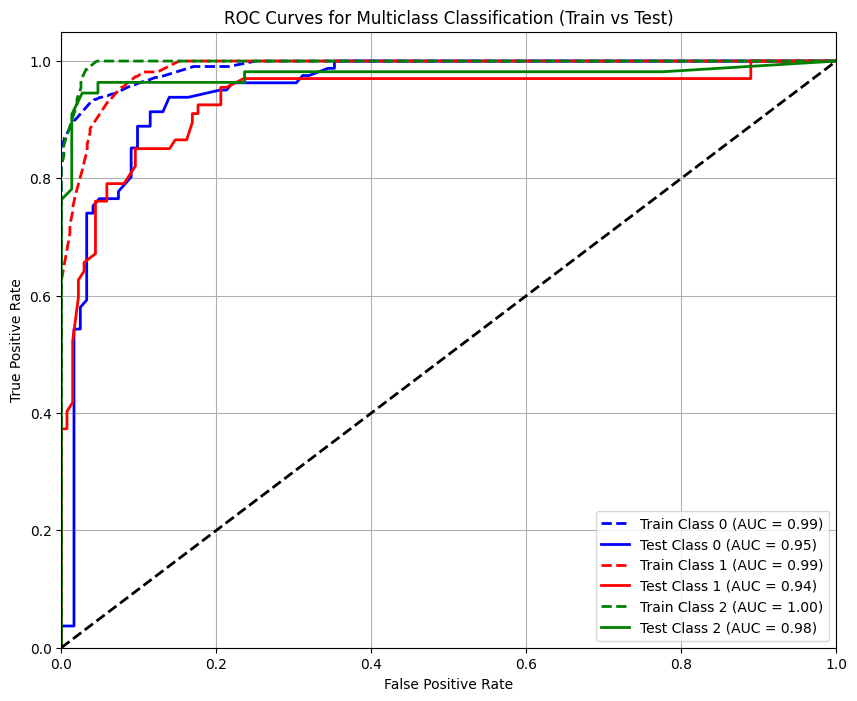

In [ ]:
plot_multiclass_roc(best_rf_model, X_train, y_train, X_test, y_test)

Random Forest имеет отличные результаты на тренировочных данных, но на тестовых данных модель немного уступает XGBoost в классификации среднего риска (класс 1).

### **XGBoost**

In [ ]:
f2_scorer = make_scorer(fbeta_score, beta=2, average='weighted')

In [ ]:

def train_xgboost(X_train, y_train):
    # Define the parameter grid
    param_grid = {
        'max_depth': [6,7,8],
        'learning_rate': [0.1],
        'n_estimators': [120,125],
        'subsample': [0.8,1.0],
        'colsample_bytree': [1.0],
        'reg_lambda': [1.0],
    }

    # Initialize StratifiedKFold
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

    # Initialize the XGBoost classifier
    xgb_model = xgb.XGBClassifier(
        objective='multi:softprob',
        num_class=3,
        eval_metric='mlogloss',
        random_state=RANDOM_STATE
    )
    sample_weights = compute_sample_weight(class_weight={0: 2, 1: 5, 2: 7}, y=y_train)

    # Initialize the GridSearchCV object
    grid_search = GridSearchCV(estimator=xgb_model,
                               param_grid=param_grid,
                               scoring=f2_scorer,
                               cv=skf,
                               n_jobs=-1,
                               verbose=1)

    # Perform the grid search on the training data
    grid_search.fit(X_train, y_train, sample_weight=sample_weights)

    # Best parameters from the grid search
    print("Best parameters found: ", grid_search.best_params_)
    print("Best cross-validation accuracy: %.2f" % grid_search.best_score_)
    print("Best cross-validation F2 Score: %.2f" % grid_search.best_score_)
    # Return the best model found by GridSearchCV
    return grid_search.best_estimator_, grid_search.best_params_




In [ ]:
def evaluate_xgboost(model, X_train, y_train, X_test, y_test):
    # Predictions on training data
    y_train_pred = model.predict(X_train)

    # Predictions on test data
    y_test_pred = model.predict(X_test)

    # Probabilities for ROC-AUC calculation
    y_train_proba = model.predict_proba(X_train)
    y_test_proba = model.predict_proba(X_test)

    # Evaluation metrics for training data
    train_f2 = fbeta_score(y_train, y_train_pred, beta=2, average='weighted')
    train_accuracy = accuracy_score(y_train, y_train_pred)
    train_roc_auc = roc_auc_score(y_train, y_train_proba, multi_class='ovo', average='weighted')

    print("Train Metrics:")
    print(f"F2 Score (weighted): {train_f2}")
    print(f"Accuracy: {train_accuracy}")
    print(f"ROC-AUC (weighted): {train_roc_auc}")

    # Confusion matrix for training data
    print("Train Confusion Matrix:")
    train_cm = confusion_matrix(y_train, y_train_pred)
    sns.heatmap(train_cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Train Confusion Matrix')
    plt.show()

    # Evaluation metrics for test data
    test_f2 = fbeta_score(y_test, y_test_pred, beta=2, average='weighted')
    test_accuracy = accuracy_score(y_test, y_test_pred)
    test_roc_auc = roc_auc_score(y_test, y_test_proba, multi_class='ovo', average='weighted')

    print("Test Metrics:")
    print(f"F2 Score (weighted): {test_f2}")
    print(f"Accuracy: {test_accuracy}")
    print(f"ROC-AUC (weighted): {test_roc_auc}")

    # Confusion matrix for test data
    print("Test Confusion Matrix:")
    test_cm = confusion_matrix(y_test, y_test_pred)
    sns.heatmap(test_cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Test Confusion Matrix')
    plt.show()


Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best parameters found:  {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 125, 'reg_lambda': 1.0, 'subsample': 0.8}
Best cross-validation accuracy: 0.84
Best cross-validation F2 Score: 0.84
Train Metrics:
F2 Score (weighted): 0.9237980060101109
Accuracy: 0.9245049504950495
ROC-AUC (weighted): 0.9925731044523081
Train Confusion Matrix:


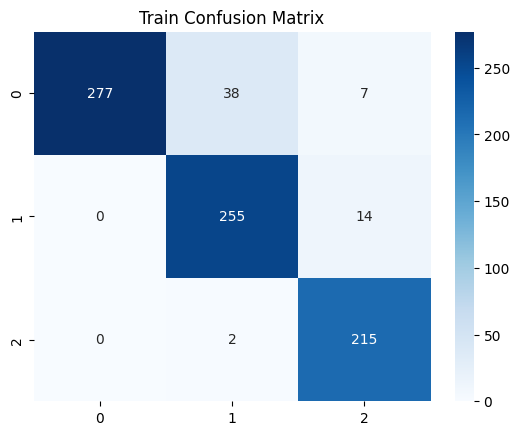

Test Metrics:
F2 Score (weighted): 0.8713595668610539
Accuracy: 0.8719211822660099
ROC-AUC (weighted): 0.9584821162964927
Test Confusion Matrix:


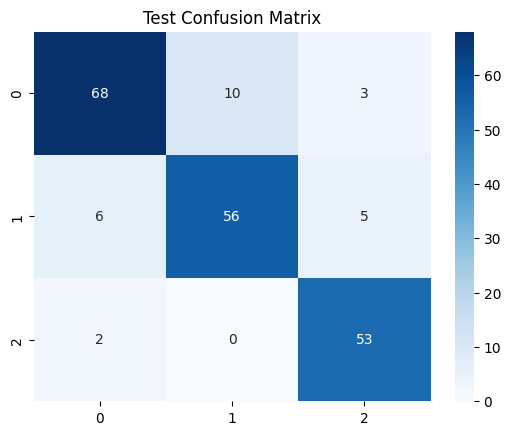

In [ ]:
# Train the model with grid search
best_model_xgb, best_params_xgb = train_xgboost(X_train, y_train)

# Evaluate the model on training and test data
evaluate_xgboost(best_model_xgb, X_train, y_train, X_test, y_test)


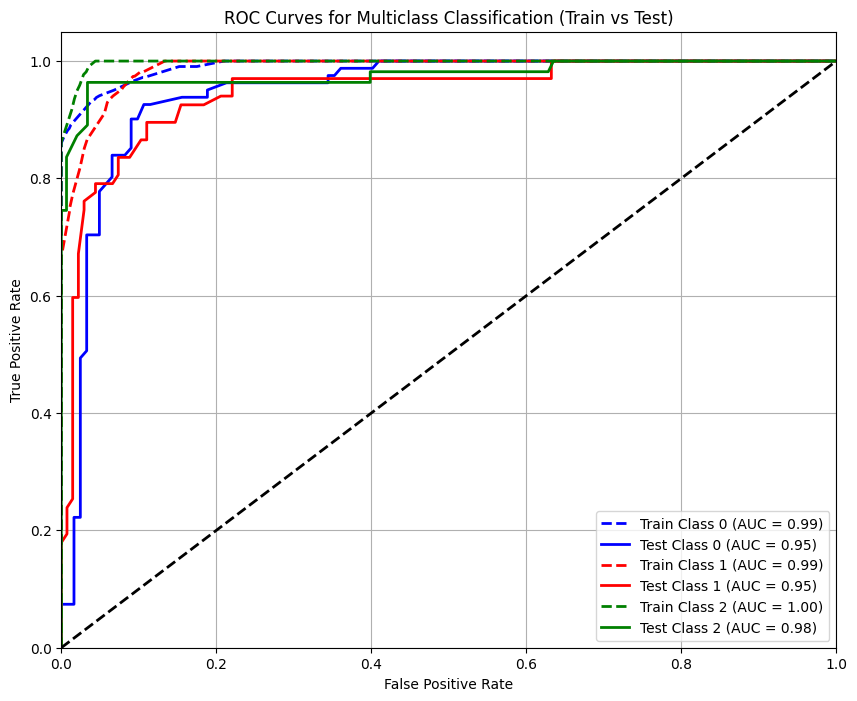

In [ ]:
plot_multiclass_roc(best_model_xgb, X_train, y_train, X_test, y_test)

ROC-кривая показывает, что XGBoost эффективно классифицирует все три класса с очень высоким ROC-AUC. Особенно важно отметить, что модель хорошо справляется с распознаванием высокого риска (класс 2), что является приоритетной задачей.

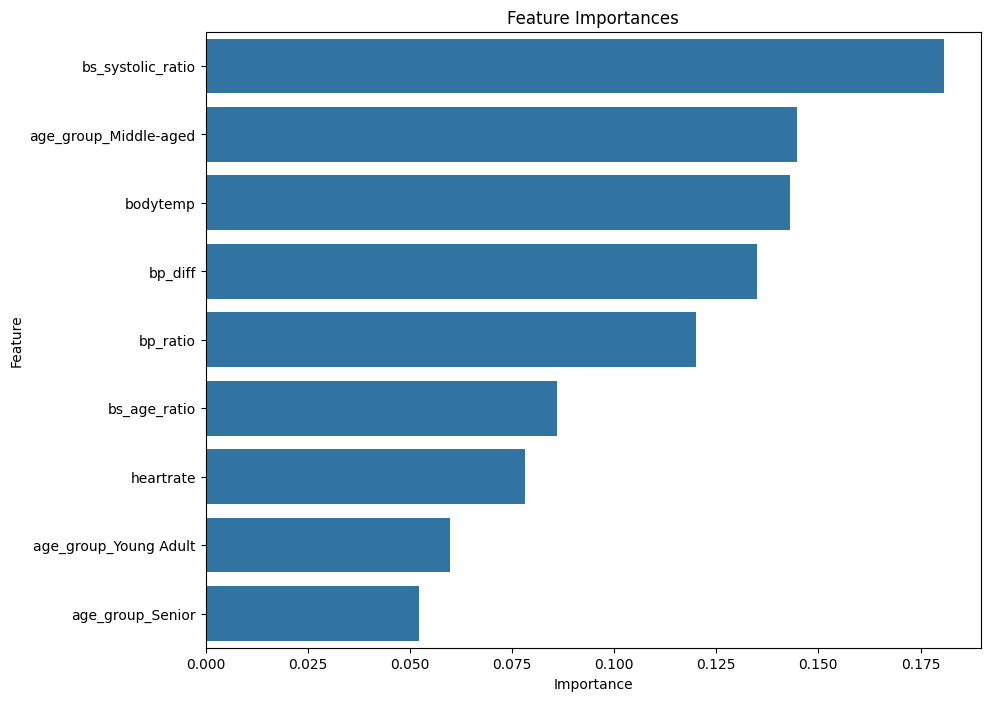

In [ ]:
# Plotting the feature importances
plot_feature_importances(best_model_xgb, feature_names)


Для XGBoost модель показала, что наибольшее влияние на предсказания оказывает показатель bs_systolic_ratio (отношение уровня сахара к систолическому давлению). Важными также оказались возрастная группа "Middle-aged" и температура тела (bodytemp), что подчеркивает роль этих признаков в оценке риска. Признаки, связанные с давлением — bp_diff и bp_ratio, — также внесли значительный вклад, а возрастные группы "Young Adult" и "Senior" оказались менее значимыми.

Random Forest (RF):  
Test Metrics:  
F2 Score (weighted): 0.8565.
Accuracy: 0.8571.
ROC-AUC (weighted): 0.9546.
XGBoost:  
Test Metrics:  
F2 Score (weighted): 0.8714.
Accuracy: 0.8719.
ROC-AUC (weighted): 0.9585.


XGBoost показал лучшие результаты на тестовых данных по всем ключевым метрикам — F2 Score (weighted), Accuracy и ROC-AUC (weighted), что делает его предпочтительным выбором для задачи классификации уровня риска

##Результаты

В ходе экспериментов были обучены две модели — **Random Forest** и **XGBoost**, с использованием данных о беременных для предсказания рисков. Оценка моделей проводилась с использованием метрики **F2** для учета важности точного выявления классов высокого и среднего риска.

Для моделей Random Forest и XGBoost был осуществлен подбор гиперпараметров с использованием Grid Search. Для XGBoost были выбраны следующие лучшие параметры: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 125, 'reg_lambda': 1.0, 'subsample': 0.8}. Для Random Forest лучшими оказались параметры: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 300}.

Модели оценивались несколько раз с разными добавленными фичами из раздела feature engineering. Были добавлены признаки, такие как соотношение систолического и диастолического давления (bp_ratio), разница между ними (bp_diff), а также соотношение уровня сахара в крови с систолическим давлением (bs_systolic_ratio) и с возрастом (bs_age_ratio). Также была введена возрастная группа (age_group), которая разделила возраст на категории.

В результате этих экспериментов было выявлено, что использование данных дополнительных признаков улучшает качество моделей. С введенными фичами обе модели показали лучшие результаты по метрикам F2 Score и ROC-AUC, особенно при классификации классов высокого и среднего риска, что является ключевым в задаче предсказания рисков для беременных.

Итоги обучения моделей:
1. **Random Forest** показала высокие результаты как на тренировочных, так и на тестовых данных. Модель продемонстрировала хорошее разделение классов, особенно высокого риска, с высоким значением **F2** и **ROC-AUC**. Тем не менее, на тестовых данных точность и **F2** были немного ниже, чем на тренировочных, что указывает на некоторое переобучение.
   
2. **XGBoost** также показала отличные результаты, с чуть более высокой **F2 Score** на тестовых данных по сравнению с **Random Forest**. Это свидетельствует о лучшей способности модели к обобщению на новых данных, что делает XGBoost немного предпочтительнее для этой задачи.


- **Random Forest** продемонстрировала **F2 Score** 0.93 на тренировочных данных и 0.86 на тестовых.
- **XGBoost** показала **F2 Score** 0.92 на тренировочных и 0.87 на тестовых данных, с чуть более высокой **ROC-AUC**.
- Обе модели хорошо справились с классификацией высокого и среднего рисков, но XGBoost лучше сбалансировала точность на тестовых данных, что делает её более предпочтительной для использования на реальных данных.

Таким образом, несмотря на то, что обе модели продемонстрировали хорошие результаты, **XGBoost** показала лучшую способность к обобщению и является предпочтительной моделью для данной задачи.

##Выводы

В ходе анализа данных и построения моделей для задачи предсказания риска беременных были проведены следующие шаги:

1. **Обзор данных:**
   Были проанализированы исходные признаки: возраст, артериальное давление (систолическое и диастолическое), уровень сахара в крови, температура тела и частота сердечных сокращений. Обнаружены выбросы, особенно в столбцах уровня сахара и температуры тела. Было решено удалить выбросы с малой частотой, чтобы избежать искажения результатов моделей.

2. **Feature Engineering:**
   Были созданы новые признаки для улучшения моделей:
   - **bp_ratio:** отношение систолического к диастолическому давлению.
   - **bp_diff:** разница между систолическим и диастолическим давлением.
   - **bs_systolic_ratio:** соотношение уровня сахара в крови и систолического давления.
   - **bs_age_ratio:** соотношение уровня сахара и возраста.
   - **age_group:** категоризация возраста на четыре группы: 'Child/Teen', 'Young Adult', 'Middle-aged', 'Senior'.

   Эти новые признаки были добавлены, чтобы учесть возможные скрытые зависимости между переменными и улучшить предсказательную способность моделей.

3. **Предобработка данных:**
   Данные были разделены на тренировочную и тестовую выборки с применением стратификации по целевому классу, что обеспечило равномерное распределение классов в обучении и тестировании.Для числовых признаков была проведена стандартизация, что позволило уравнять шкалы данных и улучшить сходимость моделей, таких как XGBoost, чувствительных к масштабу признаков. Несмотря на то, что Random Forest не требует стандартизации, этот шаг был включен для консистентности в обработке данных. Категориальные признаки были закодированы с использованием One-hot-Encoder

4. **Построение моделей:**
   Для решения задачи были выбраны две модели: Random Forest и XGBoost. Выбор этих моделей был основан на их способности эффективно работать с табличными данными и справляться с многоклассовой классификацией.

5. **Подбор гиперпараметров:**
   Осуществлен подбор гиперпараметров для обеих моделей с использованием поиска по сетке (GridSearchCV). Для обеих моделей были найдены оптимальные параметры, которые позволили добиться лучших результатов.Лучшие параметры для XGBoost: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 125, 'reg_lambda': 1.0, 'subsample': 0.8}, для Random Forest: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 300}.

6. **Оценка моделей:**
   Модели были оценены с использованием метрики F2 Score.Метрика F2 Score была выбрана для оптимизации моделей, так как она уделяет больше внимания правильному предсказанию положительных классов, что важно для идентификации высокого и среднего рисков.Особое внимание уделялось моделированию классов с высоким и средним риском, так как это наиболее критично для оценки рисков среди беременных. Дополнительно оценивались метрики **ROC-AUC** и **точность (accuracy)** для лучшего понимания работы моделей на всех классах.
   
   - **Random Forest** показала хорошие результаты, особенно при использовании добавленных признаков из feature engineering.
   - **XGBoost** также продемонстрировала высокие результаты, особенно в задачах точной классификации высокого и среднего рисков.
    

7. **Визуализация результатов:**
   Были построены ROC-кривые и матрицы ошибок для обеих моделей, что позволило оценить качество классификации для каждого класса. Также был проведен анализ важности признаков (feature importance), что позволило выявить наиболее значимые переменные для каждой модели.

**Заключение:**
В ходе работы были построены и оптимизированы модели для предсказания рисков беременных. Цель и задачи выполнены. В результате экспериментов и feature engineering удалось улучшить качество предсказаний.

Для дальнейшего улучшения предсказательной способности модели я бы порекомендовала увеличить объем данных, что может повысить точность прогнозирования, особенно для классов высокого риска. Дополнение выборки новыми признаками, такими как индекс массы тела или другие медицинские параметры, также может улучшить предсказательную способность модели.

##Вывод метрик лучшей модели XGBoost

Train Metrics:
F2 Score (weighted): 0.9237980060101109
Accuracy: 0.9245049504950495
ROC-AUC (weighted): 0.9925731044523081
Train Confusion Matrix:


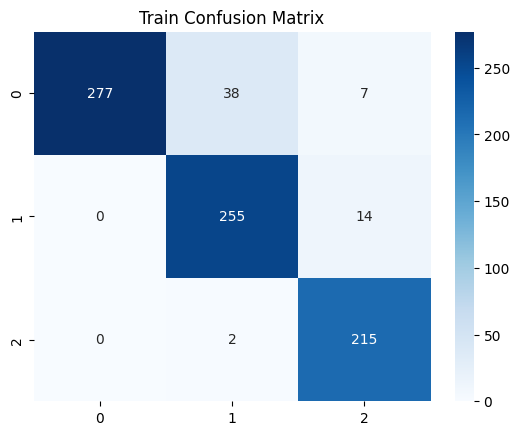

Test Metrics:
F2 Score (weighted): 0.8713595668610539
Accuracy: 0.8719211822660099
ROC-AUC (weighted): 0.9584821162964927
Test Confusion Matrix:


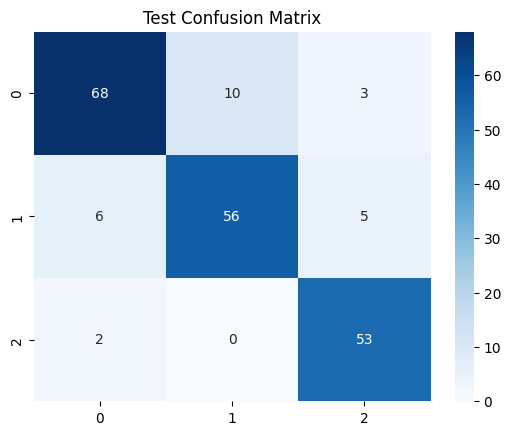

In [ ]:
# Evaluate the model on training and test data
evaluate_xgboost(best_model_xgb, X_train, y_train, X_test, y_test)